# Final Classification Project Notebook

### Environment Setup and Data Loading

In [20]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

data_path = Path.cwd().parent.joinpath('data')
df = pd.read_csv(data_path.joinpath('data.csv'))
df['ismetro']=df['ismetro'].astype(int)
df.head()

,fips,family,case_id,state_abv.,county,housing,food,transportation,healthcare,other_necessities,...,taxes,total,median_family_income,popestimate2024,snap_total_participants,snap_rate,state_fips,county_fips,county_upper,ismetro
0,2013.0,1p0c,1.0,AK,Aleutians East Borough,957.0,449.35,1244.18,728.58,473.17,...,637.57,4489.85,78889.0,3632.0,442.477148,0.121827,20.0,13.0,ALEUTIANS EAST BOROUGH,0
1,2013.0,1p1c,1.0,AK,Aleutians East Borough,1358.0,660.69,1495.45,1168.69,679.20,...,906.14,7103.82,78889.0,3632.0,442.477148,0.121827,20.0,13.0,ALEUTIANS EAST BOROUGH,0
2,2013.0,1p2c,1.0,AK,Aleutians East Borough,1358.0,970.53,1613.71,1608.80,783.45,...,1248.95,9165.94,78889.0,3632.0,442.477148,0.121827,20.0,13.0,ALEUTIANS EAST BOROUGH,0
3,2013.0,1p3c,1.0,AK,Aleutians East Borough,1642.0,1294.73,1695.64,2048.91,988.08,...,1621.27,11102.93,78889.0,3632.0,442.477148,0.121827,20.0,13.0,ALEUTIANS EAST BOROUGH,0
4,2013.0,1p4c,1.0,AK,Aleutians East Borough,1642.0,1585.45,1808.71,2489.02,1085.90,...,1937.03,12360.41,78889.0,3632.0,442.477148,0.121827,20.0,13.0,ALEUTIANS EAST BOROUGH,0


### Feature Engineering and Dataset Preparation

In [2]:
share_cols = ['housing','food','transportation','healthcare','childcare','other_necessities','taxes']
for col in share_cols:
    df[col + '_share'] = df[col] / df['total']

drop_cols = (
    share_cols + 
    ['county','county_upper','case_id','fips','total',
     'snap_total_participants','popestimate2024',
     'median_family_income','state_fips','county_fips']
)

df = df.drop(columns=drop_cols)

num_features = [c for c in df.columns if '_share' in c] + ['snap_rate']
cat_features = ['family','state_abv.']

X = df.drop(columns=['ismetro'])
y = df['ismetro']

### Exploratory Data Analysis (EDA)
- #### Distribution of the Target Variable (ismetro)

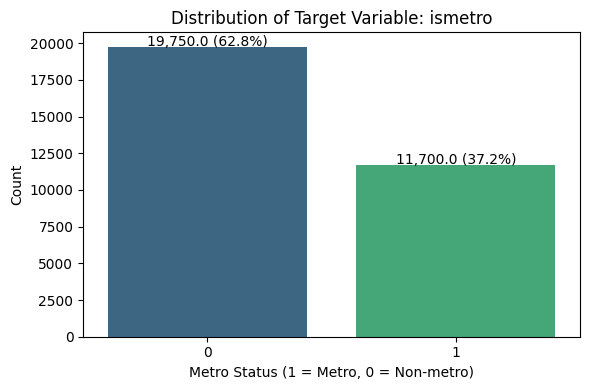

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='ismetro', hue='ismetro', data=df, palette='viridis', legend=False)

plt.title("Distribution of Target Variable: ismetro")
plt.xlabel("Metro Status (1 = Metro, 0 = Non-metro)")
plt.ylabel("Count")

total = len(df)
for p in plt.gca().patches:
    count = p.get_height()
    plt.text(p.get_x() + p.get_width()/2,
             count + total*0.002,
             f"{count:,} ({count/total:.1%})",
             ha='center')

plt.tight_layout()
plt.show()

- #### Correlation Heatmap of All Numeric Features

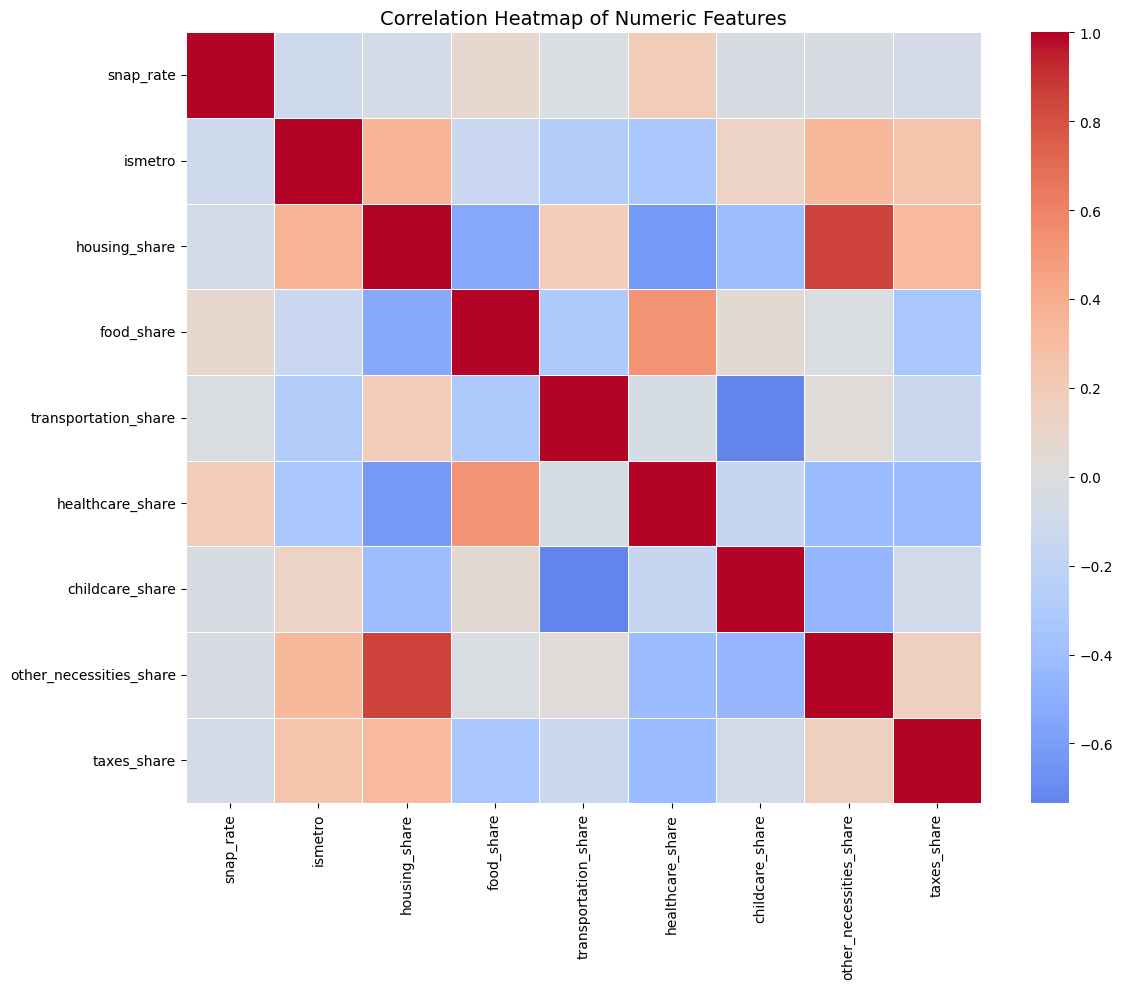

In [4]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])

corr = numeric_df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(
    corr,
    annot=False,
    cmap='coolwarm',
    center=0,
    linewidths=0.4
)

plt.title("Correlation Heatmap of Numeric Features", fontsize=14)
plt.tight_layout()
plt.show()

- #### Correlation of Numeric Features With Target (ismetro)

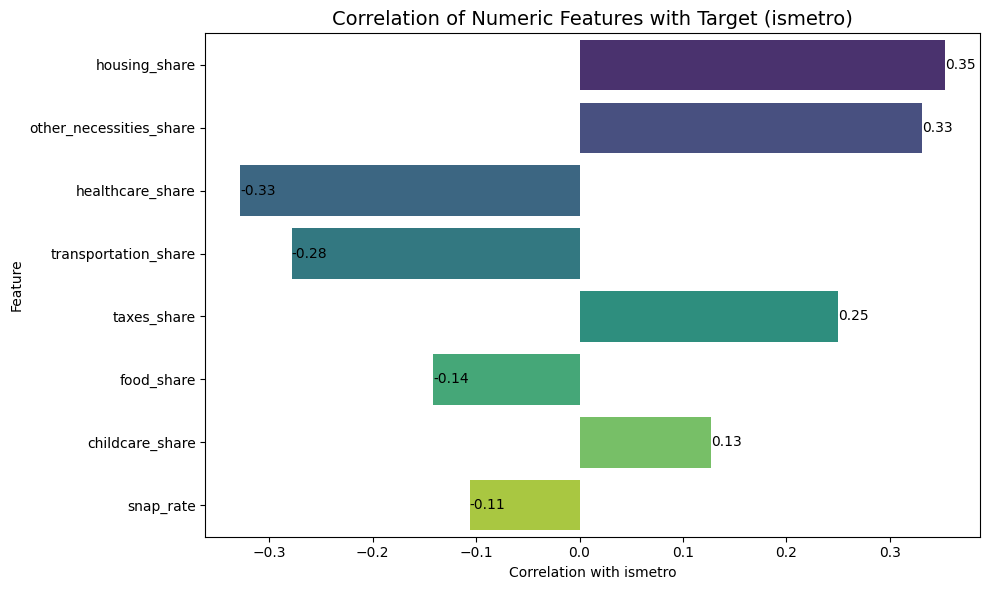

In [5]:
target_corr = corr['ismetro'].drop('ismetro').sort_values(key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x=target_corr.values,
    y=target_corr.index,
    hue=target_corr.index, 
    palette="viridis",
    dodge=False,
    legend=False                
)

plt.title("Correlation of Numeric Features with Target (ismetro)", fontsize=14)
plt.xlabel("Correlation with ismetro")
plt.ylabel("Feature")

for i, v in enumerate(target_corr.values):
    plt.text(v, i, f"{v:.2f}", ha='left', va='center')

plt.tight_layout()
plt.show()

- #### Pairplot of Top Predictive Features

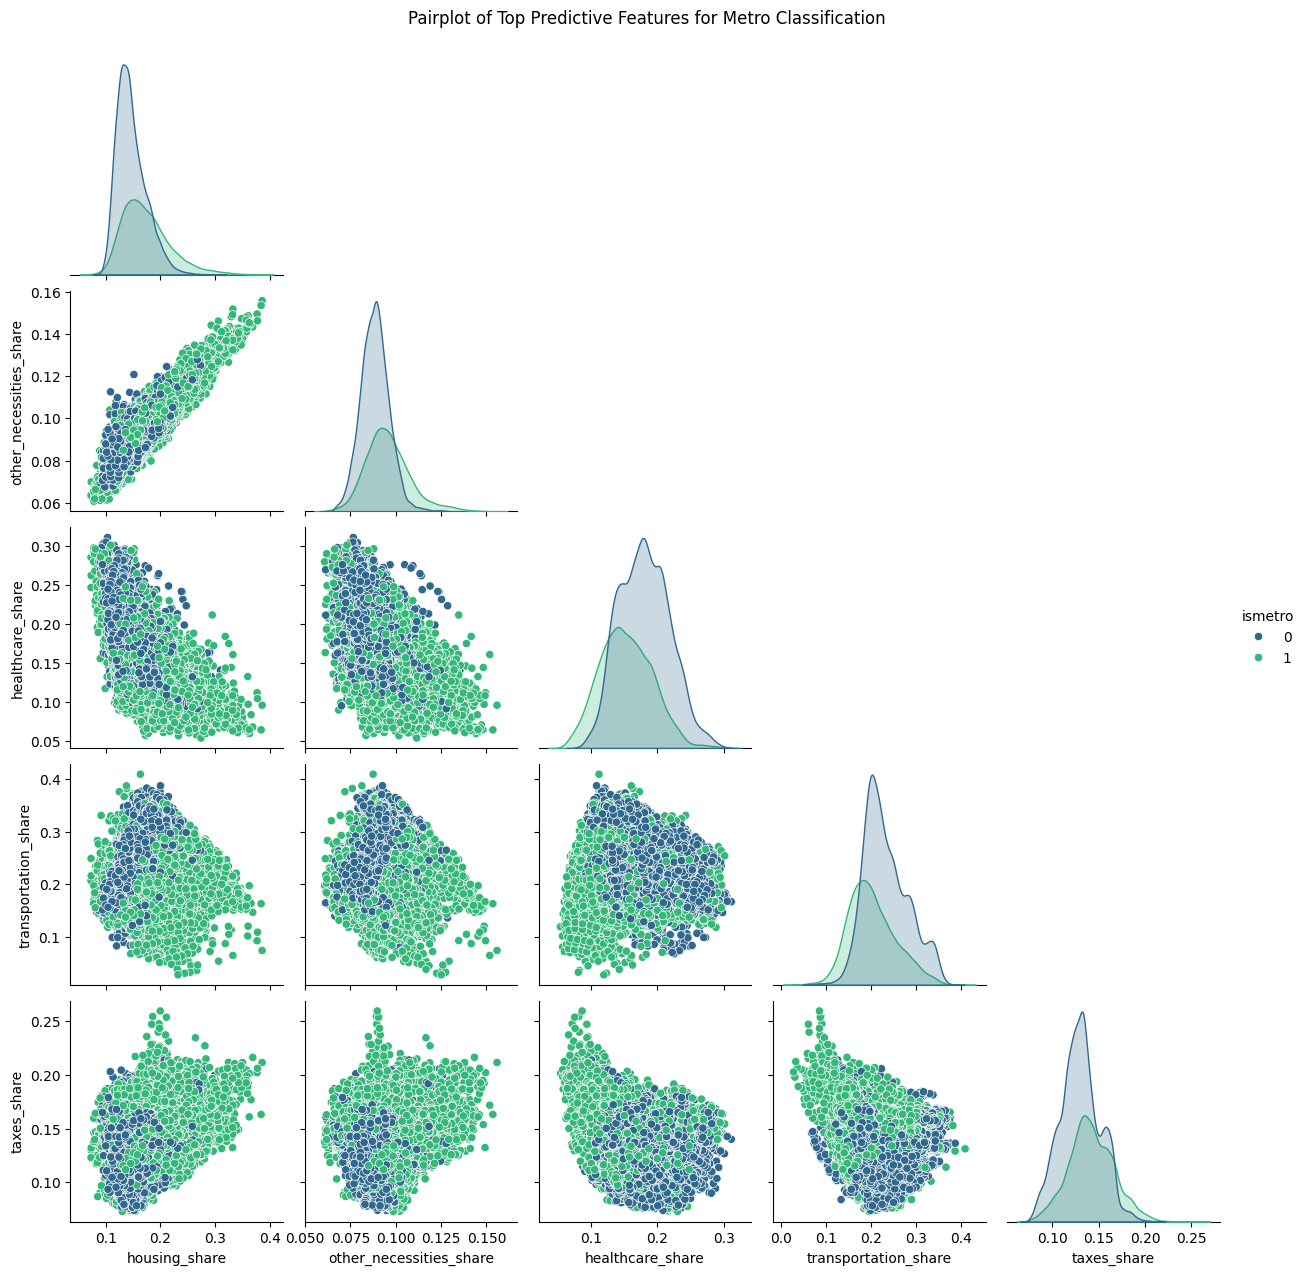

In [6]:
top_features = target_corr.head(5).index.tolist()

sns.pairplot(
    df[top_features + ['ismetro']],
    hue='ismetro',
    diag_kind='kde',
    corner=True,
    palette='viridis'
)

plt.suptitle("Pairplot of Top Predictive Features for Metro Classification", y=1.02)
plt.show()

### Train / Validation / Test Split

In [7]:
X_train, X_temp, y_train, y_temp=train_test_split(X,y,test_size=0.4,stratify=y,random_state=42)
X_val, X_test, y_val, y_test=train_test_split(X_temp,y_temp,test_size=0.5,stratify=y_temp,random_state=42)

### Preprocessing Pipeline

In [8]:
preprocess=ColumnTransformer([
    ('num', Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ]), num_features),
    ('cat', Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_features)
])

### PCA Projection

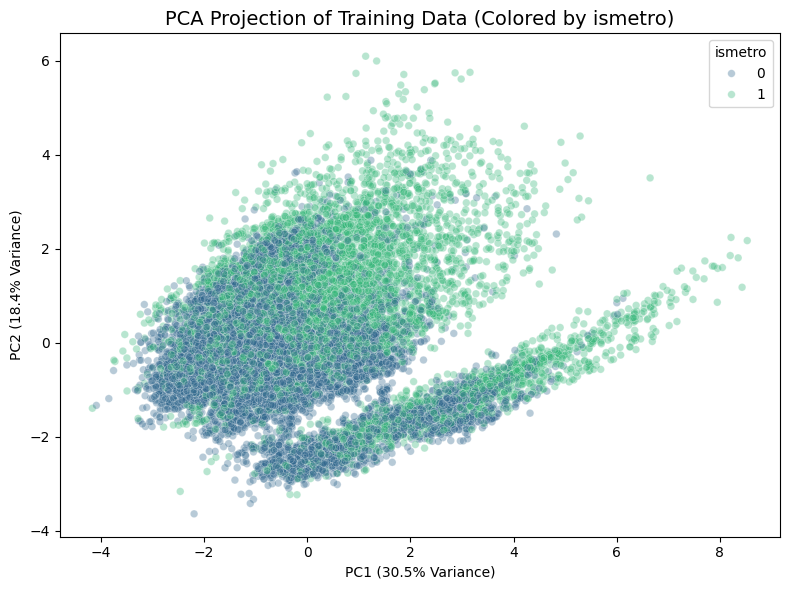

In [ ]:
X_train_prep = preprocess.fit_transform(X_train)

X_val_prep = preprocess.transform(X_val)
X_test_prep = preprocess.transform(X_test)

pca = PCA(n_components=2, random_state=42)
pca_train = pca.fit_transform(X_train_prep)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=pca_train[:, 0],
    y=pca_train[:, 1],
    hue=y_train,
    palette='viridis',
    alpha=0.35,
    s=30,
    legend=True
)

plt.title("PCA Projection of Training Data (Colored by ismetro)", fontsize=14)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% Variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% Variance)")
plt.tight_layout()
plt.show()

### Evaluation Function

In [12]:

results=[]
def evaluate_model(name, model, Xtr, ytr, Xv, yv, balanced=False):
    model.fit(Xtr,ytr)
    y_pred=model.predict(Xv)
    y_proba=model.predict_proba(Xv)[:,1]
    f1=classification_report(yv,y_pred,output_dict=True)['weighted avg']['f1-score']
    auc=roc_auc_score(yv,y_proba)
    results.append({
        'Model':name+(' (Balanced)' if balanced else ' (Unbalanced)'),
        'Validation F1':round(f1,4),
        'Validation ROC AUC':round(auc,4)
    })

### Train Models (Unbalanced)

In [13]:
models={
 'LogReg':LogisticRegression(max_iter=2000),
 'DecisionTree':DecisionTreeClassifier(max_depth=12),
 'RandomForest':RandomForestClassifier(n_estimators=200, max_depth=18),
 'GradientBoosting':GradientBoostingClassifier(),
 'NeuralNet':MLPClassifier(hidden_layer_sizes=(64,32),max_iter=500,early_stopping=True)
}


for name,model in models.items():
    pipe=Pipeline([('prep',preprocess),(name,model)])
    evaluate_model(name,pipe,X_train,y_train,X_val,y_val)

In [14]:
svc_pipe = Pipeline([
    ('prep', preprocess),
    ('svc', SVC(probability=True, C=3))
])

evaluate_model("SVC", svc_pipe, X_train, y_train, X_val, y_val)

### Train Models (Balanced with SMOTE)

In [15]:
sm=SMOTE(random_state=42)

for name,model in models.items():
    pipe=ImbPipeline([('prep',preprocess),('sm',sm),(name,model)])
    evaluate_model(name,pipe,X_train,y_train,X_val,y_val,balanced=True)

/Users/mutsamungoshi/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mutsamungoshi/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mutsamungoshi/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn

#### Combined Feature Importance Summary

/var/folders/4m/_fg19tl1739c5j7rvwwqvy3m0000gn/T/ipykernel_93405/2807389820.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


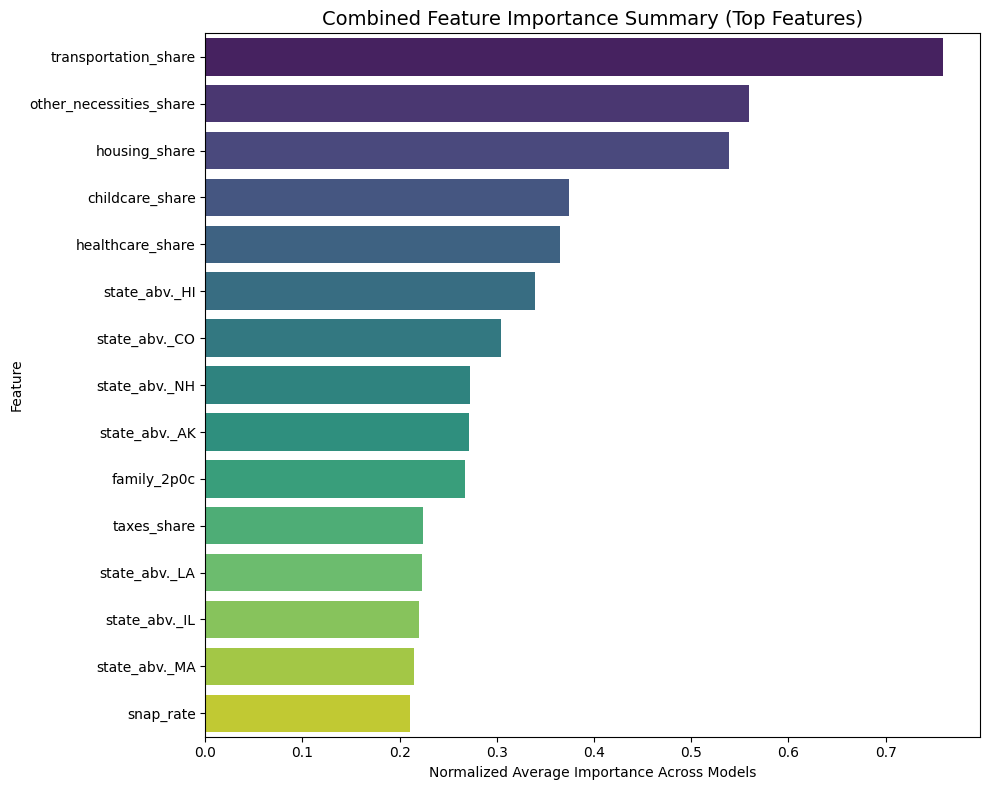

,LogisticRegression,RandomForest,GradientBoosting,MeanImportance
transportation_share,0.277599,1.000000,1.000000,0.759200
other_necessities_share,0.046743,0.899639,0.731542,0.559308
housing_share,0.191377,0.806817,0.618317,0.538837
childcare_share,0.250136,0.556043,0.317188,0.374456
healthcare_share,0.256137,0.649710,0.187774,0.364540
state_abv._HI,1.000000,0.010122,0.007931,0.339351
state_abv._CO,0.780227,0.057954,0.075281,0.304487
state_abv._NH,0.793891,0.011444,0.013048,0.272794
state_abv._AK,0.660537,0.054082,0.098865,0.271161
family_2p0c,0.777567,0.021437,0.001504,0.266836


In [16]:
logit = Pipeline([
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=2000))
])
logit.fit(X_train, y_train)

ohe = logit.named_steps['prep'].named_transformers_['cat']['onehot']
cat_feature_names = list(ohe.get_feature_names_out(cat_features))

all_features = num_features + cat_feature_names

logit_importance = pd.Series(
    np.abs(logit.named_steps['clf'].coef_[0]),
    index=all_features,
    name='LogisticRegression'
)

rf = Pipeline([
    ('prep', preprocess),
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=18, random_state=42))
])
rf.fit(X_train, y_train)

rf_importance = pd.Series(
    rf.named_steps['rf'].feature_importances_,
    index=all_features,
    name='RandomForest'
)

gb = Pipeline([
    ('prep', preprocess),
    ('gb', GradientBoostingClassifier(random_state=42))
])
gb.fit(X_train, y_train)

gb_importance = pd.Series(
    gb.named_steps['gb'].feature_importances_,
    index=all_features,
    name='GradientBoosting'
)

importance_df = pd.concat([logit_importance, rf_importance, gb_importance], axis=1)

importance_norm = importance_df / importance_df.max()

importance_norm['MeanImportance'] = importance_norm.mean(axis=1)

top_features = importance_norm['MeanImportance'].sort_values(ascending=False).head(15)

plt.figure(figsize=(10,8))
sns.barplot(
    x=top_features.values,
    y=top_features.index,
    palette='viridis'
)

plt.title("Combined Feature Importance Summary (Top Features)", fontsize=14)
plt.xlabel("Normalized Average Importance Across Models")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

importance_norm.sort_values('MeanImportance', ascending=False).head(15)

### Validation Results Table

In [17]:
results_df=pd.DataFrame(results)
results_df = results_df.sort_values('Validation ROC AUC', ascending=False).reset_index(drop=True)
results_df

,Model,Validation F1,Validation ROC AUC
0,NeuralNet (Unbalanced),0.8908,0.9541
1,NeuralNet (Balanced),0.8849,0.9525
2,SVC (Unbalanced),0.8732,0.9291
3,RandomForest (Balanced),0.8414,0.9152
4,RandomForest (Unbalanced),0.8293,0.9120
5,GradientBoosting (Balanced),0.8217,0.8889
6,GradientBoosting (Unbalanced),0.8156,0.8851
7,LogReg (Balanced),0.8157,0.8776
8,LogReg (Unbalanced),0.8221,0.8770
9,DecisionTree (Balanced),0.8107,0.8204


#### Balanced vs Unbalanced Comparison Table

In [18]:
results_df['Balanced'] = results_df['Model'].apply(
    lambda x: 'Balanced' if 'Balanced' in x else 'Unbalanced'
)

results_df['BaseModel'] = results_df['Model'].str.replace(' (Balanced)', '', regex=False)
results_df['BaseModel'] = results_df['BaseModel'].str.replace(' (Unbalanced)', '', regex=False)

comparison = results_df.pivot_table(
    index='BaseModel',
    columns='Balanced',
    values='Validation ROC AUC',
    aggfunc='max'
)

comparison = comparison[['Unbalanced', 'Balanced']]
comparison.columns = ['Unbalanced AUC', 'Balanced AUC']

comparison

,Unbalanced AUC,Balanced AUC
BaseModel,,
DecisionTree,0.8093,0.8204
GradientBoosting,0.8851,0.8889
LogReg,0.8770,0.8776
NeuralNet,0.9541,0.9525
RandomForest,0.9120,0.9152
SVC,0.9291,NaN


#### Final Model Selection and Test Evaluation

/Users/mutsamungoshi/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Best model based on validation AUC: NeuralNet

=== FINAL TEST PERFORMANCE ===
Test ROC AUC: 0.9528
Test F1 Score: 0.8864


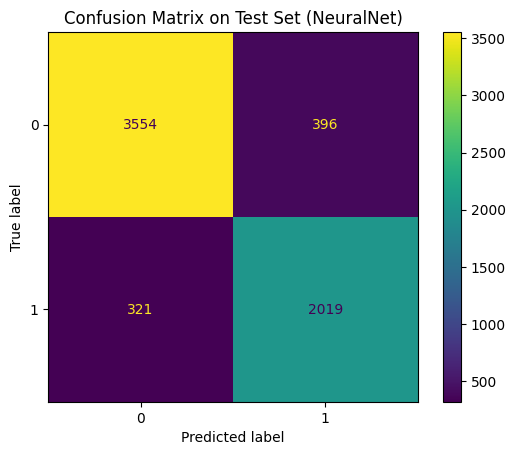

In [19]:
best_row = results_df.sort_values('Validation ROC AUC', ascending=False).iloc[0]
best_model_name = best_row['BaseModel']
print("Best model based on validation AUC:", best_model_name)

best_estimator = models[best_model_name]

X_final_train = pd.concat([X_train, X_val])
y_final_train = pd.concat([y_train, y_val])

final_model = ImbPipeline([
    ('prep', preprocess),
    ('sm', SMOTE(random_state=42)),
    ('clf', best_estimator)
])

final_model.fit(X_final_train, y_final_train)

y_pred_test = final_model.predict(X_test)
y_proba_test = final_model.predict_proba(X_test)[:, 1]

test_f1 = classification_report(y_test, y_pred_test, output_dict=True)['weighted avg']['f1-score']
test_auc = roc_auc_score(y_test, y_proba_test)

print("\n=== FINAL TEST PERFORMANCE ===")
print("Test ROC AUC:", round(test_auc, 4))
print("Test F1 Score:", round(test_f1, 4))

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="viridis")
plt.title(f"Confusion Matrix on Test Set ({best_model_name})")
plt.show()

#### Final ROC Curve

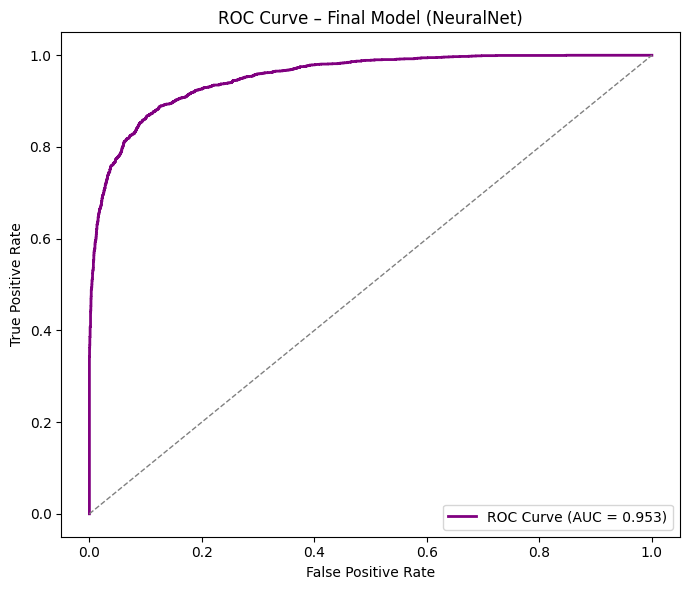

In [21]:
y_proba_test = final_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='purple', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – Final Model ({best_model_name})")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()